In [3]:
import os
import pickle

import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from hbmep.config import Config
from hbmep.model.utils import Site as site

from models import NonHierarchicalBayesianModel
from constants import (
    TOML_PATH,
    DATA_PATH,
    BUILD_DIR,
)


COLUMNS = ["participant", "compound_position", "compound_charge_params"]


In [4]:
src = os.path.join(BUILD_DIR, "inference.pkl")
with open(src, "rb") as f:
    COMBINED_COMBINATIONS, COMBINED_POSTERIOR_SAMPLES = pickle.load(f)

DATA = pd.read_csv(DATA_PATH)
print(DATA.shape)

config = Config(TOML_PATH)
model = NonHierarchicalBayesianModel(config)


(16440, 44)


## Midline - Lateral

In [5]:
combinations = [
    c for c in COMBINED_COMBINATIONS if (
        # Remove 80-0-20-400 charge
        c[2] != "80-0-20-400" and
        # Remove ground contacts
        "" not in c[1].split("-") and
        # At the same segment
        c[1].split("-")[0][:-1] == c[1].split("-")[1][:-1]
    )
]

combinations;

ind = [c in combinations for c in COMBINED_COMBINATIONS]
posterior_samples = {
    u: v[:, ind, ...] for u, v in COMBINED_POSTERIOR_SAMPLES.items()
}


In [6]:
directions = ["L-M", "M-L"]
segments = ["C6", "C7", "C8"]
charges = ['20-0-80-25', '50-0-50-0', '50-0-50-100']
subjects = sorted(DATA["participant"].unique().tolist())

a = None
a_mask = None

for subject in subjects:
    for direction in directions:
        for segment in segments:
            for charge in charges:
                compound_position = f"{segment}{direction[:-1]}{segment}{direction[-1]}"
                curr_combination = (subject, compound_position, charge)
                if curr_combination in combinations:
                    ind = [c == curr_combination for c in combinations]
                    assert sum(ind) == 1
                    if a is None:
                        a = posterior_samples[site.a][:, ind, ...]
                        a_mask = np.full(a.shape, False)
                    else:
                        a = np.concatenate([a, posterior_samples[site.a][:, ind, ...]], axis=1)
                        a_mask = np.concatenate(
                            [
                                a_mask,
                                np.full(
                                    (
                                        posterior_samples[site.a].shape[0],
                                        1,
                                        posterior_samples[site.a].shape[-1]
                                    ),
                                    False
                                )
                            ],
                            axis=1
                        )
                else:
                    if a is None:
                        a = np.zeros((
                            posterior_samples[site.a].shape[0],
                            1,
                            posterior_samples[site.a].shape[-1]
                        ))
                        a_mask = np.full(a.shape, True)
                    else:
                        a = np.concatenate(
                            [
                                a,
                                np.zeros((
                                    posterior_samples[site.a].shape[0],
                                    1,
                                    posterior_samples[site.a].shape[-1]
                                ))
                            ],
                            axis=1
                        )
                        a_mask = np.concatenate(
                            [
                                a_mask,
                                np.full(
                                    (
                                        posterior_samples[site.a].shape[0],
                                        1,
                                        posterior_samples[site.a].shape[-1],
                                    ),
                                    True
                                ),
                            ],
                            axis=1
                        )


a = a.reshape(
    -1, len(subjects), len(directions), len(segments), len(charges), *a.shape[2:]
)
a_mask = a_mask.reshape(
    -1, len(subjects), len(directions), len(segments), len(charges), *a_mask.shape[2:]
)

a = ma.masked_array(a, mask=a_mask)
a.shape


(4000, 8, 2, 3, 3, 6)

In [48]:
def _heatmap_horizontal(segments_ind):
    arr = []
    arr_labels = []

    for l_direction_ind, l_direction in enumerate(directions):
        for l_charge_ind, l_charge in enumerate(charges):
            match l_charge:
                case "20-0-80-25": l_charge_name = "P. Mono"
                case "50-0-50-0": l_charge_name = "Monophasic"
                case "50-0-50-100": l_charge_name = "Biphasic"
                case _: raise ValueError(f"Unknown charge: {l_charge}")
            label = f"{l_direction}\n{l_charge_name}"
            arr_labels.append(label)

            for r_direction_ind, r_direction in enumerate(directions):
                for r_charge_ind, r_charge in enumerate(charges):
                    if (l_direction_ind == r_direction_ind) and (l_charge_ind == r_charge_ind):
                        arr.append(1)
                        continue

                    l_samples = a[:, :, l_direction_ind, segments_ind, l_charge_ind, ...].mean(axis=0)
                    r_samples = a[:, :, r_direction_ind, segments_ind, r_charge_ind, ...].mean(axis=0)
                    pvalue = stats.ttest_1samp(l_samples - r_samples, popmean=0, alternative="less", axis=(0, 1, 2)).pvalue
                    arr.append(pvalue)

    arr = np.array(arr)
    arr = arr.reshape(-1, len(arr_labels))
    arr_mask = np.diag(arr)
    return arr, arr_labels, arr_mask


ValueError: Mask must have the same shape as data.

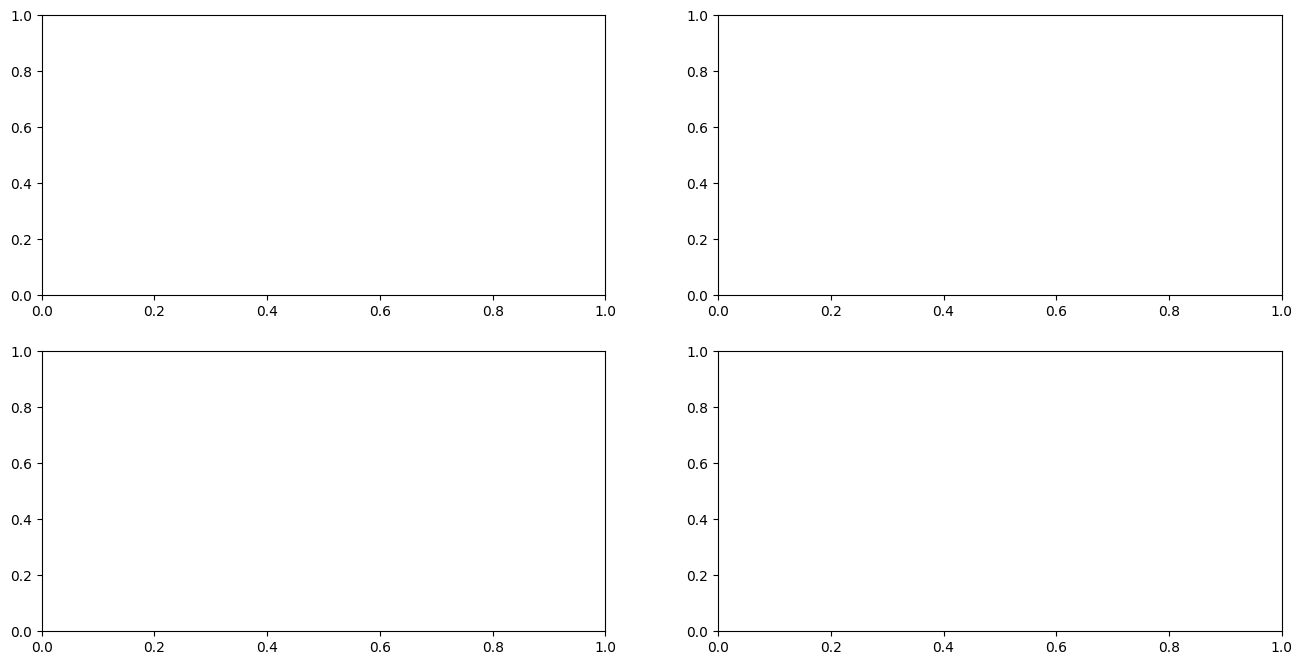

In [74]:
heatmap_kwargs = {
    "linewidths":1, "linecolor":"black", "cbar": False, "vmin": 0, "vmax": 1
}

nrows, ncols = 2, 2
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 8, nrows * 4),
    squeeze=False,
)

for segment_ind, segment in enumerate(segments):
    segments_ind = [segment_ind]
    arr, arr_labels, arr_mask = _heatmap_horizontal(segments_ind)
    ax = axes[segment_ind // ncols, segment_ind % ncols]
    sns.heatmap(arr, xticklabels=arr_labels, yticklabels=arr_labels, annot=True, ax=ax, mask=np.diag(arr_mask), **heatmap_kwargs)
    ax.tick_params(axis="x", rotation=0)
    match segment:
        case "C6": num_rats = 5
        case "C7": num_rats = 8
        case "C8": num_rats = 3
        case _: raise ValueError(f"Unknown segment: {segment}")
    ax.set_title(f"Segment {segment} - {num_rats} rats")

ax = axes[-1, -1]
segments_ind = [0, 1, 2]
arr, arr_labels, arr_mask = _heatmap_horizontal(segments_ind)
sns.heatmap(arr, xticklabels=arr_labels, yticklabels=arr_labels, annot=True, ax=ax, mask=np.diag(arr_mask), **heatmap_kwargs)
ax.tick_params(axis="x", rotation=0)
ax.set_title(f"All segments: {', '.join(segments)}");

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.2, hspace=.35)


## Vertical

In [52]:
combinations = [
    c for c in COMBINED_COMBINATIONS if (
        # Remove 80-0-20-400 charge
        c[2] != "80-0-20-400" and
        # Remove ground contacts
        "" not in c[1].split("-") and
        # Not at the same segment
        c[1].split("-")[0][:-1] != c[1].split("-")[1][:-1]
    )
]

combinations;

ind = [c in combinations for c in COMBINED_COMBINATIONS]
posterior_samples = {
    u: v[:, ind, ...] for u, v in COMBINED_POSTERIOR_SAMPLES.items()
}


In [53]:
set([u[1] for u in combinations])

{'C6L-C7L', 'C7L-C6L', 'C7L-C8L', 'C8L-C7L'}

In [54]:
directions = ["R-C", "C-R"]
segments = ["C6-C7", "C7-C8"]
charges = ['20-0-80-25', '50-0-50-0', '50-0-50-100']
subjects = sorted(DATA["participant"].unique().tolist())

a = None
a_mask = None

for subject in subjects:
    for direction in directions:
        for segment in segments:
            for charge in charges:
                compound_position = segment.split("-")
                if direction == "C-R":
                    compound_position = compound_position[::-1]
                compound_position = (
                    f"{compound_position[0]}L-{compound_position[1]}L"
                )
                curr_combination = (subject, compound_position, charge)
                if curr_combination in combinations:
                    ind = [c == curr_combination for c in combinations]
                    assert sum(ind) == 1
                    if a is None:
                        a = posterior_samples[site.a][:, ind, ...]
                        a_mask = np.full(a.shape, False)
                    else:
                        a = np.concatenate([a, posterior_samples[site.a][:, ind, ...]], axis=1)
                        a_mask = np.concatenate(
                            [
                                a_mask,
                                np.full(
                                    (
                                        posterior_samples[site.a].shape[0],
                                        1,
                                        posterior_samples[site.a].shape[-1]
                                    ),
                                    False
                                )
                            ],
                            axis=1
                        )
                else:
                    if a is None:
                        a = np.zeros((
                            posterior_samples[site.a].shape[0],
                            1,
                            posterior_samples[site.a].shape[-1]
                        ))
                        a_mask = np.full(a.shape, True)
                    else:
                        a = np.concatenate(
                            [
                                a,
                                np.zeros((
                                    posterior_samples[site.a].shape[0],
                                    1,
                                    posterior_samples[site.a].shape[-1]
                                ))
                            ],
                            axis=1
                        )
                        a_mask = np.concatenate(
                            [
                                a_mask,
                                np.full(
                                    (
                                        posterior_samples[site.a].shape[0],
                                        1,
                                        posterior_samples[site.a].shape[-1],
                                    ),
                                    True
                                ),
                            ],
                            axis=1
                        )


a = a.reshape(
    -1, len(subjects), len(directions), len(segments), len(charges), *a.shape[2:]
)
a_mask = a_mask.reshape(
    -1, len(subjects), len(directions), len(segments), len(charges), *a_mask.shape[2:]
)

a = ma.masked_array(a, mask=a_mask)
a.shape


(4000, 8, 2, 2, 3, 6)

In [58]:
def _heatmap_horizontal(segments_ind):
    arr = []
    arr_labels = []

    for l_direction_ind, l_direction in enumerate(directions):
        for l_charge_ind, l_charge in enumerate(charges):
            match l_charge:
                case "20-0-80-25": l_charge_name = "P. Mono"
                case "50-0-50-0": l_charge_name = "Monophasic"
                case "50-0-50-100": l_charge_name = "Biphasic"
                case _: raise ValueError(f"Unknown charge: {l_charge}")
            label = f"{l_direction}\n{l_charge_name}"
            arr_labels.append(label)

            for r_direction_ind, r_direction in enumerate(directions):
                for r_charge_ind, r_charge in enumerate(charges):
                    if (l_direction_ind == r_direction_ind) and (l_charge_ind == r_charge_ind):
                        arr.append(1)
                        continue

                    l_samples = a[:, :, l_direction_ind, segments_ind, l_charge_ind, ...].mean(axis=0)
                    r_samples = a[:, :, r_direction_ind, segments_ind, r_charge_ind, ...].mean(axis=0)
                    pvalue = stats.ttest_1samp(l_samples - r_samples, popmean=0, alternative="less", axis=(0, 1, 2)).pvalue
                    arr.append(pvalue)

    arr = np.array(arr)
    arr = arr.reshape(-1, len(arr_labels))
    arr_mask = np.triu(arr)
    return arr, arr_labels, arr_mask


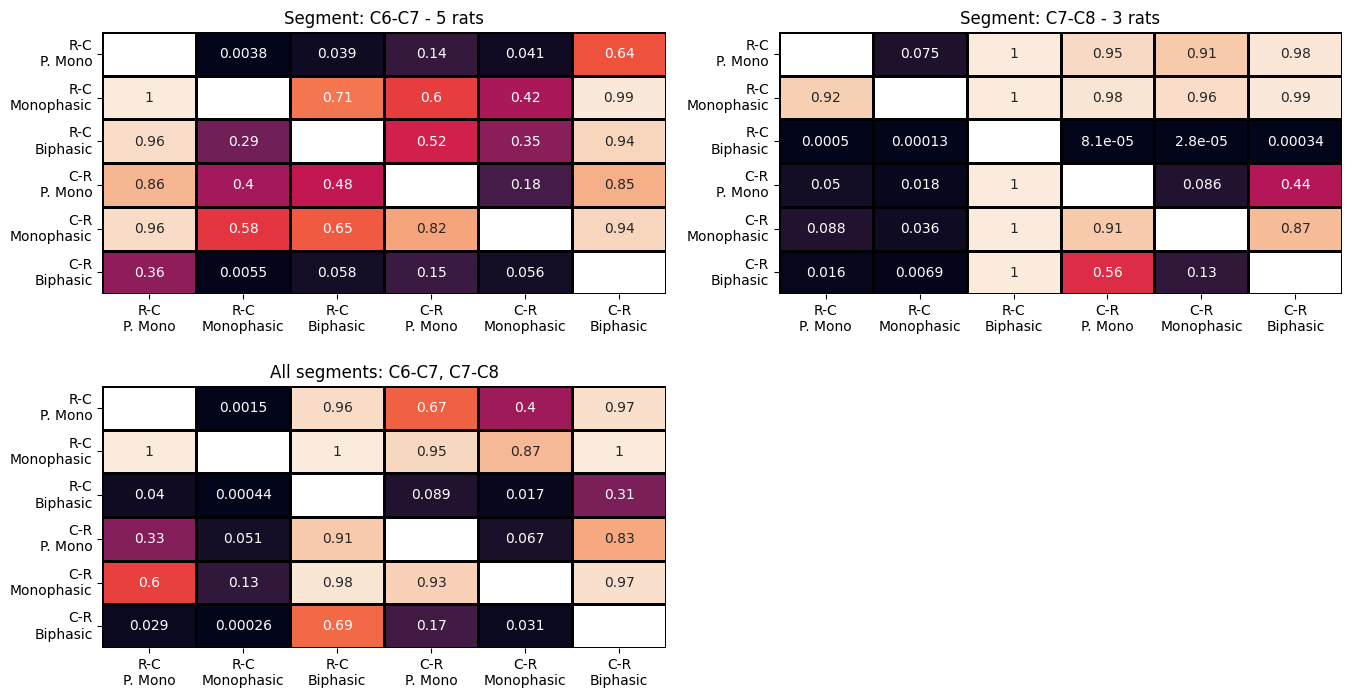

In [73]:
heatmap_kwargs = {
    "linewidths":1, "linecolor":"black", "cbar": False, "vmin": 0, "vmax": 1
}

nrows, ncols = 2, 2
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 8, nrows * 4),
    squeeze=False
)

for segment_ind, segment in enumerate(segments):
    segments_ind = [segment_ind]
    arr, arr_labels, arr_mask = _heatmap_horizontal(segments_ind)
    ax = axes[segment_ind // ncols, segment_ind % ncols]
    sns.heatmap(arr, xticklabels=arr_labels, yticklabels=arr_labels, annot=True, ax=ax, mask=np.diag(np.diag(arr)), **heatmap_kwargs)
    ax.tick_params(axis="x", rotation=0)
    match segment:
        case "C6-C7": num_rats = 5
        case "C7-C8": num_rats = 3
        case _: raise ValueError(f"Unknown segment: {segment}")
    ax.set_title(f"Segment: {segment} - {num_rats} rats")

ax = axes[-1, 0]
segments_ind = [0, 1]
arr, arr_labels, arr_mask = _heatmap_horizontal(segments_ind)
sns.heatmap(arr, xticklabels=arr_labels, yticklabels=arr_labels, annot=True, ax=ax, mask=np.diag(np.diag(arr)), **heatmap_kwargs)
ax.tick_params(axis="x", rotation=0)
ax.set_title(f"All segments: {', '.join(segments)}");

ax = axes[-1, -1]
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax.tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.2, hspace=.35)


In [24]:
DATA.compound_position.unique()

array(['C7M-C7L', 'C7L-', 'C8L-C7L', 'C8L-C8M', '-C8L', 'C8L-', 'C7L-C8L',
       'C7L-C7M', 'C8M-C8L', '-C7L', 'C6M-C6L', 'C6L-C6M', '-C6L',
       'C7L-C6L', 'C6L-', 'C6L-C7L'], dtype=object)

In [ ]:
def filter_data(keep_combinations):
    df = DATA.copy()
    ind = (
        df[COLUMNS[1:]]
        .apply(tuple, axis=1)
        .isin(keep_combinations)
    )
    df = df[ind].reset_index(drop=True).copy()

    combinations = [
        (position, charge) in keep_combinations
        for subject, position, charge in COMBINED_COMBINATIONS
    ]
    posterior_samples = {
        u: v[:, combinations, ...]
        for u, v in COMBINED_POSTERIOR_SAMPLES.items()
    }
    combinations = [u for u, v in zip(COMBINED_COMBINATIONS, combinations) if v]
    return df, combinations, posterior_samples


### C6

In [ ]:
segment = "C6"

keep_combinations = [
    (f'{segment}L-{segment}M', '20-0-80-25'),
    (f'{segment}L-{segment}M', '50-0-50-0'),
    (f'{segment}L-{segment}M', '50-0-50-100'),
    (f'{segment}M-{segment}L', '20-0-80-25'),
    (f'{segment}M-{segment}L', '50-0-50-0'),
    (f'{segment}M-{segment}L', '50-0-50-100')
]
print(keep_combinations)

df, combinations, posterior_samples = filter_data(keep_combinations)
print(df.shape)

subjects = sorted(df[COLUMNS[0]].unique())
positions = sorted(df[COLUMNS[1]].unique())
charges = sorted(df[COLUMNS[2]].unique())

a = None
for subject in subjects:
    for position in positions:
        for charge in charges:
            ind = [(subject, position, charge) == u for u in combinations]
            assert sum(ind) == 1
            if a is None:
                a = posterior_samples[site.a][:, ind, ...]
            else:
                a = np.concatenate([a, posterior_samples[site.a][:, ind, ...]], axis=1)
a = a.reshape(-1, len(subjects), len(positions), len(charges), *a.shape[2:])


[('C6L-C6M', '20-0-80-25'), ('C6L-C6M', '50-0-50-0'), ('C6L-C6M', '50-0-50-100'), ('C6M-C6L', '20-0-80-25'), ('C6M-C6L', '50-0-50-0'), ('C6M-C6L', '50-0-50-100')]
(1700, 44)


In [ ]:
ind = 0
print(f"{positions[ind]}")

for i, l in enumerate(charges):
    for j, r in enumerate(charges):
        if l == r: continue
        l_samples = a[:, :, ind, ...].mean(axis=0)[:, i, :]
        r_samples = a[:, :, ind, ...].mean(axis=0)[:, j, :]
        pvalue = stats.ttest_1samp(l_samples - r_samples, popmean=0, alternative="less", axis=(0, 1)).pvalue
        print(
            f"{l}\t<\t{r}:\t{pvalue}"
        )


C6L-C6M
20-0-80-25	<	50-0-50-0:	0.14793920528642757
20-0-80-25	<	50-0-50-100:	0.8274810020121071
50-0-50-0	<	20-0-80-25:	0.8520607947135724
50-0-50-0	<	50-0-50-100:	0.9510321493122068
50-0-50-100	<	20-0-80-25:	0.172518997987893
50-0-50-100	<	50-0-50-0:	0.04896785068779322


In [ ]:
ind = 1
print(f"{positions[ind]}")

for i, l in enumerate(charges):
    for j, r in enumerate(charges):
        if l == r: continue
        l_samples = a[:, :, ind, ...].mean(axis=0)[:, i, :]
        r_samples = a[:, :, ind, ...].mean(axis=0)[:, j, :]
        pvalue = stats.ttest_1samp(l_samples - r_samples, popmean=0, alternative="less", axis=(0, 1)).pvalue
        print(
            f"{l}\t<\t{r}:\t{pvalue}"
        )


C6M-C6L
20-0-80-25	<	50-0-50-0:	0.26696554047407195
20-0-80-25	<	50-0-50-100:	0.9999939475335555
50-0-50-0	<	20-0-80-25:	0.7330344595259279
50-0-50-0	<	50-0-50-100:	0.9999911144505081
50-0-50-100	<	20-0-80-25:	6.052466444464677e-06
50-0-50-100	<	50-0-50-0:	8.8855494918964e-06


In [ ]:
for i, charge in enumerate(charges):
    print(f"\n{charge}")
    l_samples = a.mean(axis=0)[:, 0, i, :]
    r_samples = a.mean(axis=0)[:, 1, i, :]
    pvalue = stats.ttest_1samp(l_samples - r_samples, popmean=0, alternative="less", axis=(0, 1)).pvalue
    print(
        f"{positions[0]}\t\t<\t{positions[1]}:\t{pvalue}"
    )
    pvalue = stats.ttest_1samp(-(l_samples - r_samples), popmean=0, alternative="less", axis=(0, 1 )).pvalue
    print(
        f"{positions[1]}\t\t<\t{positions[0]}:\t{pvalue}"
    )



20-0-80-25
C6L-C6M		<	C6M-C6L:	0.006694745092699479
C6M-C6L		<	C6L-C6M:	0.9933052549073005

50-0-50-0
C6L-C6M		<	C6M-C6L:	0.08821828462729775
C6M-C6L		<	C6L-C6M:	0.9117817153727023

50-0-50-100
C6L-C6M		<	C6M-C6L:	0.999489549259464
C6M-C6L		<	C6L-C6M:	0.0005104507405359901


### C7

In [ ]:
segment = "C7"

keep_combinations = [
    (f'{segment}L-{segment}M', '20-0-80-25'),
    (f'{segment}L-{segment}M', '50-0-50-0'),
    (f'{segment}L-{segment}M', '50-0-50-100'),
    (f'{segment}M-{segment}L', '20-0-80-25'),
    (f'{segment}M-{segment}L', '50-0-50-0'),
    (f'{segment}M-{segment}L', '50-0-50-100')
]
print(keep_combinations)

df, combinations, posterior_samples = filter_data(keep_combinations)
print(df.shape)

subjects = sorted(df[COLUMNS[0]].unique())
positions = sorted(df[COLUMNS[1]].unique())
charges = sorted(df[COLUMNS[2]].unique())

a = None
for subject in subjects:
    for position in positions:
        for charge in charges:
            ind = [(subject, position, charge) == u for u in combinations]
            assert sum(ind) == 1
            if a is None:
                a = posterior_samples[site.a][:, ind, ...]
            else:
                a = np.concatenate([a, posterior_samples[site.a][:, ind, ...]], axis=1)
a = a.reshape(-1, len(subjects), len(positions), len(charges), *a.shape[2:])


[('C7L-C7M', '20-0-80-25'), ('C7L-C7M', '50-0-50-0'), ('C7L-C7M', '50-0-50-100'), ('C7M-C7L', '20-0-80-25'), ('C7M-C7L', '50-0-50-0'), ('C7M-C7L', '50-0-50-100')]
(2538, 44)


In [ ]:
ind = 0
print(f"{positions[ind]}")

for i, l in enumerate(charges):
    for j, r in enumerate(charges):
        if l == r: continue
        l_samples = a[:, :, ind, ...].mean(axis=0)[:, i, :]
        r_samples = a[:, :, ind, ...].mean(axis=0)[:, j, :]
        pvalue = stats.ttest_1samp(l_samples - r_samples, popmean=0, alternative="less", axis=(0, 1)).pvalue
        print(
            f"{l}\t<\t{r}:\t{pvalue}"
        )


C7L-C7M
20-0-80-25	<	50-0-50-0:	0.01655868339747997
20-0-80-25	<	50-0-50-100:	0.9972770669479791
50-0-50-0	<	20-0-80-25:	0.9834413166025201
50-0-50-0	<	50-0-50-100:	0.9998204541013415
50-0-50-100	<	20-0-80-25:	0.002722933052020838
50-0-50-100	<	50-0-50-0:	0.00017954589865860462


In [ ]:
ind = 1
print(f"{positions[ind]}")

for i, l in enumerate(charges):
    for j, r in enumerate(charges):
        if l == r: continue
        l_samples = a[:, :, ind, ...].mean(axis=0)[:, i, :]
        r_samples = a[:, :, ind, ...].mean(axis=0)[:, j, :]
        pvalue = stats.ttest_1samp(l_samples - r_samples, popmean=0, alternative="less", axis=(0, 1)).pvalue
        print(
            f"{l}\t<\t{r}:\t{pvalue}"
        )


C7M-C7L
20-0-80-25	<	50-0-50-0:	0.00019613924377859693
20-0-80-25	<	50-0-50-100:	0.9647021304501868
50-0-50-0	<	20-0-80-25:	0.9998038607562214
50-0-50-0	<	50-0-50-100:	0.999959643225194
50-0-50-100	<	20-0-80-25:	0.035297869549813156
50-0-50-100	<	50-0-50-0:	4.0356774805902716e-05


In [ ]:
for i, charge in enumerate(charges):
    print(f"\n{charge}")
    l_samples = a.mean(axis=0)[:, 0, i, :]
    r_samples = a.mean(axis=0)[:, 1, i, :]
    pvalue = stats.ttest_1samp(l_samples - r_samples, popmean=0, alternative="less", axis=(0, 1)).pvalue
    print(
        f"{positions[0]}\t\t<\t{positions[1]}:\t{pvalue}"
    )
    pvalue = stats.ttest_1samp(-(l_samples - r_samples), popmean=0, alternative="less", axis=(0, 1 )).pvalue
    print(
        f"{positions[1]}\t\t<\t{positions[0]}:\t{pvalue}"
    )



20-0-80-25
C7L-C7M		<	C7M-C7L:	0.03433866720964922
C7M-C7L		<	C7L-C7M:	0.9656613327903507

50-0-50-0
C7L-C7M		<	C7M-C7L:	0.024988469217498404
C7M-C7L		<	C7L-C7M:	0.9750115307825016

50-0-50-100
C7L-C7M		<	C7M-C7L:	0.00016024548851842194
C7M-C7L		<	C7L-C7M:	0.9998397545114815


### C8

In [ ]:
segment = "C8"

keep_combinations = [
    (f'{segment}L-{segment}M', '20-0-80-25'),
    (f'{segment}L-{segment}M', '50-0-50-0'),
    (f'{segment}L-{segment}M', '50-0-50-100'),
    (f'{segment}M-{segment}L', '20-0-80-25'),
    (f'{segment}M-{segment}L', '50-0-50-0'),
    (f'{segment}M-{segment}L', '50-0-50-100')
]
print(keep_combinations)

df, combinations, posterior_samples = filter_data(keep_combinations)
print(df.shape)

subjects = sorted(df[COLUMNS[0]].unique())
positions = sorted(df[COLUMNS[1]].unique())
charges = sorted(df[COLUMNS[2]].unique())

a = None
for subject in subjects:
    for position in positions:
        for charge in charges:
            ind = [(subject, position, charge) == u for u in combinations]
            assert sum(ind) == 1
            if a is None:
                a = posterior_samples[site.a][:, ind, ...]
            else:
                a = np.concatenate([a, posterior_samples[site.a][:, ind, ...]], axis=1)
a = a.reshape(-1, len(subjects), len(positions), len(charges), *a.shape[2:])


[('C8L-C8M', '20-0-80-25'), ('C8L-C8M', '50-0-50-0'), ('C8L-C8M', '50-0-50-100'), ('C8M-C8L', '20-0-80-25'), ('C8M-C8L', '50-0-50-0'), ('C8M-C8L', '50-0-50-100')]
(918, 44)


In [ ]:
ind = 0
print(f"{positions[ind]}")

for i, l in enumerate(charges):
    for j, r in enumerate(charges):
        if l == r: continue
        l_samples = a[:, :, ind, ...].mean(axis=0)[:, i, :]
        r_samples = a[:, :, ind, ...].mean(axis=0)[:, j, :]
        pvalue = stats.ttest_1samp(l_samples - r_samples, popmean=0, alternative="less", axis=(0, 1)).pvalue
        print(
            f"{l}\t<\t{r}:\t{pvalue}"
        )


C8L-C8M
20-0-80-25	<	50-0-50-0:	0.9045188548538926
20-0-80-25	<	50-0-50-100:	0.5484505883682095
50-0-50-0	<	20-0-80-25:	0.09548114514610742
50-0-50-0	<	50-0-50-100:	0.07904059840151013
50-0-50-100	<	20-0-80-25:	0.4515494116317905
50-0-50-100	<	50-0-50-0:	0.9209594015984899


In [ ]:
ind = 1
print(f"{positions[ind]}")

for i, l in enumerate(charges):
    for j, r in enumerate(charges):
        if l == r: continue
        l_samples = a[:, :, ind, ...].mean(axis=0)[:, i, :]
        r_samples = a[:, :, ind, ...].mean(axis=0)[:, j, :]
        pvalue = stats.ttest_1samp(l_samples - r_samples, popmean=0, alternative="less", axis=(0, 1)).pvalue
        print(
            f"{l}\t<\t{r}:\t{pvalue}"
        )


C8M-C8L
20-0-80-25	<	50-0-50-0:	0.6918855408725308
20-0-80-25	<	50-0-50-100:	0.5087228495675026
50-0-50-0	<	20-0-80-25:	0.3081144591274692
50-0-50-0	<	50-0-50-100:	0.31413492689380174
50-0-50-100	<	20-0-80-25:	0.4912771504324975
50-0-50-100	<	50-0-50-0:	0.6858650731061982


In [ ]:
for i, charge in enumerate(charges):
    print(f"\n{charge}")
    l_samples = a.mean(axis=0)[:, 0, i, :]
    r_samples = a.mean(axis=0)[:, 1, i, :]
    pvalue = stats.ttest_1samp(l_samples - r_samples, popmean=0, alternative="less", axis=(0, 1)).pvalue
    print(
        f"{positions[0]}\t\t<\t{positions[1]}:\t{pvalue}"
    )
    pvalue = stats.ttest_1samp(-(l_samples - r_samples), popmean=0, alternative="less", axis=(0, 1 )).pvalue
    print(
        f"{positions[1]}\t\t<\t{positions[0]}:\t{pvalue}"
    )



20-0-80-25
C8L-C8M		<	C8M-C8L:	0.4745788154831838
C8M-C8L		<	C8L-C8M:	0.5254211845168162

50-0-50-0
C8L-C8M		<	C8M-C8L:	0.12327170570132633
C8M-C8L		<	C8L-C8M:	0.8767282942986736

50-0-50-100
C8L-C8M		<	C8M-C8L:	0.4131853706816174
C8M-C8L		<	C8L-C8M:	0.5868146293183825
